In [1]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import pandas as pd
import matplotlib.pyplot
from matplotlib import pyplot as plt

In [2]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.03
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 10
PHI = []
IsSynthetic = False

In [3]:
def OpenFeatures():
    fea = pd.read_csv("HumanObserved-Features-Data.csv", sep=",", index_col=1).loc[:,"f1":]
    return fea

In [4]:
def OpenSamePair():
    sam = pd.read_csv("same_pairs.csv", sep=",") 
    return sam

In [5]:
def OpenDiffPair():
    diff = pd.read_csv("diffn_pairs.csv", sep=",")
    return diff

In [6]:
def GenTargetData():
    t = OpenFeatures()
    h = OpenSamePair()
    p = OpenDiffPair()
    a1 = h["img_id_A"]
    a2 = t.loc[a1].reset_index(drop=True)
    a3 = h["img_id_B"]
    a4 = t.loc[a3].reset_index(drop=True)
    a5 = p["img_id_A"][:791]
    a6 = t.loc[a5].reset_index(drop=True)
    a7 = p["img_id_B"][:791]
    a8 = t.loc[a7].reset_index(drop=True)
    a12 = h["target"]
    a14 = p["target"][:791]
    a2.columns = a2.columns+"F"
    a6.columns = a6.columns+"F"
    a9 = pd.concat([a12, a2, a4], axis = 1)
    a10 = pd.concat([a14, a6, a8], axis = 1)
    a11 = pd.concat([a9, a10])
    return a11

In [7]:
t = GenTargetData()
a1 = t.sample(frac=1)
a1 = a1.reset_index(drop=True)
a2 = a1["target"].reset_index(drop=True)
a3 = a1.loc[:,"f1F":].reset_index(drop=True)
pd.Series(a2).to_csv("target.csv", index=False)
pd.DataFrame(a3).to_csv("data.csv",header =False, index=False)
a1

KeyError: 'None of [0        0001a_num1.png\n1        0001a_num1.png\n2        0001a_num1.png\n3        0001a_num1.png\n4        0001a_num1.png\n5        0001a_num1.png\n6        0001a_num1.png\n7        0001a_num1.png\n8        0001a_num1.png\n9        0001a_num1.png\n10       0001a_num1.png\n11       0001a_num1.png\n12       0001a_num1.png\n13       0001a_num1.png\n14       0001a_num2.png\n15       0001a_num2.png\n16       0001a_num2.png\n17       0001a_num2.png\n18       0001a_num2.png\n19       0001a_num2.png\n20       0001a_num2.png\n21       0001a_num2.png\n22       0001a_num2.png\n23       0001a_num2.png\n24       0001a_num2.png\n25       0001a_num2.png\n26       0001a_num2.png\n27       0001a_num3.png\n28       0001a_num3.png\n29       0001a_num3.png\n              ...      \n71501    1566a_num3.png\n71502    1566a_num3.png\n71503    1566b_num1.png\n71504    1566b_num1.png\n71505    1566b_num1.png\n71506    1566b_num1.png\n71507    1566b_num1.png\n71508    1566b_num2.png\n71509    1566b_num2.png\n71510    1566b_num2.png\n71511    1566b_num2.png\n71512    1566b_num3.png\n71513    1566b_num3.png\n71514    1566b_num3.png\n71515    1566b_num4.png\n71516    1566b_num4.png\n71517    1566c_num1.png\n71518    1567b_num1.png\n71519    1567b_num1.png\n71520    1567b_num3.png\n71521    1568a_num1.png\n71522    1568a_num1.png\n71523    1568a_num1.png\n71524    1568a_num1.png\n71525    1568a_num2.png\n71526    1568a_num2.png\n71527    1568a_num2.png\n71528    1568a_num3.png\n71529    1568a_num3.png\n71530    1568c_num1.png\nName: img_id_A, Length: 71531, dtype: object] are in the [index]'

In [148]:
def GetTargetVector(filePath):
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
    #print("Raw Training Generated..")
    return t

#open the file and read it by row and column, store them as a matrix.
def GenerateRawData(filePath, IsSynthetic):    
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    
    if IsSynthetic == False :
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1)
    dataMatrix = np.transpose(dataMatrix)     
    #print ("Data Matrix Generated..")
    return dataMatrix
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

#split the input data(x) to 80% for trainning data, and also store it in a matrix by columns.
def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

#valdata takes 10% of the input data, and increase the size of the matrix, then store the 10% data in a matrix. 
def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

#Generate the 10% valdata to be the target vector.
def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

#Convert input to vector into a scalar value.
def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

#Using getscalar function to get the basis function  φj (x)
def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

#Calculate phi, This type of model uses the kernel of the normal (or Gaussian) probability density function (PDF)
def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

#calculate the closed form based on the function by pluging in phi, Lambda, and T
def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W

#multiply the closed form with the phi of the valdata
def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

#Calculate the error for valdata in order to get the accuracy.
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

In [149]:
RawTarget = GetTargetVector('target.csv')
RawData   = GenerateRawData('data.csv',IsSynthetic)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 'U' mode is deprecated
  del sys.path[0]


In [150]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

(1266,)
(13, 1266)


In [151]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(158,)
(13, 158)


In [152]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(158,)
(13, 158)


In [153]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

In [154]:
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

(10, 13)
(13, 13)
(1266, 10)
(10,)
(158, 10)
(157, 10)


In [155]:
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))

In [156]:
print ('UBITname      = yunbao')
print ('Person Number = 50159678')
print ('----------------------------------------------------')
print ("------------------LeToR Data------------------------")
print ('----------------------------------------------------')
print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')
print ("M = 10 \nLambda = 0.9")
print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))

UBITname      = yunbao
Person Number = 50159678
----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 10 
Lambda = 0.9
E_rms Training   = 0.36951147231755493
E_rms Validation = 0.37669065109783867
E_rms Testing    = 0.3984012570399766


In [157]:
print ('----------------------------------------------------')
print ('--------------Please Wait for 2 mins!----------------')
print ('----------------------------------------------------')

----------------------------------------------------
--------------Please Wait for 2 mins!----------------
----------------------------------------------------


In [158]:
W_Now        = np.dot(220, W)
La           = 2
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
Acc_Val   = []
Acc_TR    = []
Acc_Test  = []
W_Mat        = []

for i in range(0,400):
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    Acc_TR.append(float(Erms_TR.split(',')[0]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    Acc_Val.append(float(Erms_Val.split(',')[0]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))
    Acc_Test.append(float(Erms_Test.split(',')[0]))

----------Gradient Descent Solution--------------------
M = 15 
Lambda  = 0.0001
eta=0.01
E_rms Training   = 0.3851
E_rms Validation = 0.40037
E_rms Testing    = 0.4284
0.5255808747082297


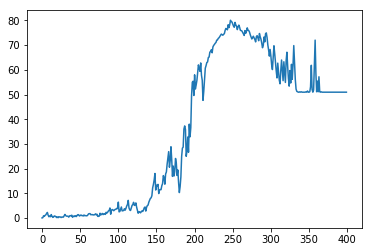

In [159]:
print ('----------Gradient Descent Solution--------------------')
print ("M = 15 \nLambda  = 0.0001\neta=0.01")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

pd.Series(Acc_TR).plot()
print(L_Erms_TR[-1])

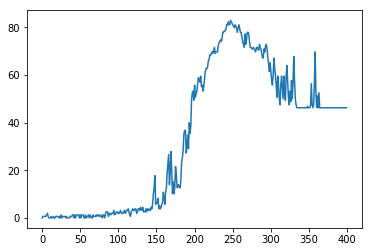

In [160]:

pd.Series(Acc_Val).plot()

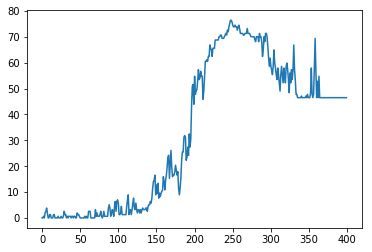

In [161]:

pd.Series(Acc_Test).plot()